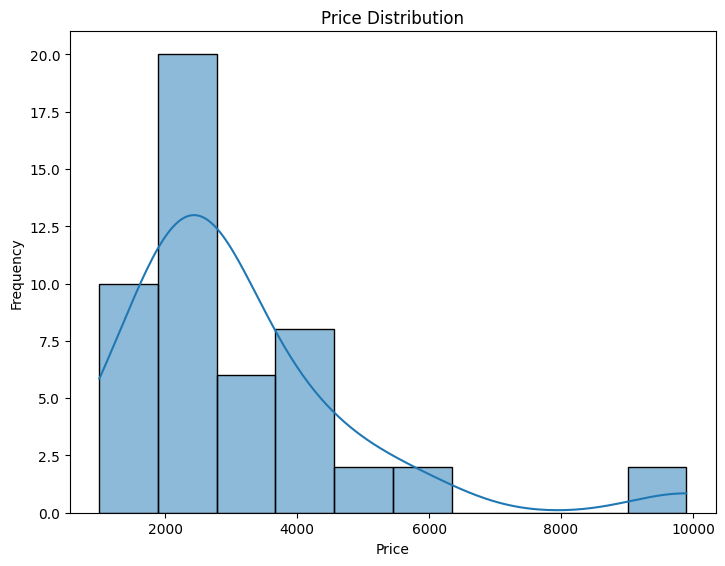

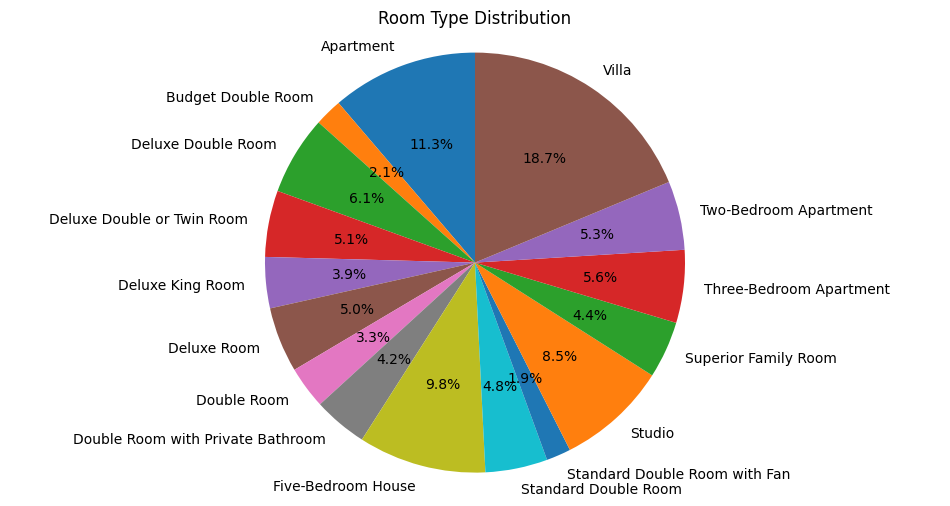

In [5]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns

# Load the CSV data
data = pd.read_csv("Kottayam_2023-06-11.csv")

# Calculate room type statistics
room_type_stats = data.groupby('type').agg(
    max_price=('price', 'max'),
    min_price=('price', 'min'),
    mean_price=('price', 'mean'),
    avg_reviews=('ratings', 'mean')
).reset_index()

# Create the Tkinter application
app = tk.Tk()
window_width = 1920
window_height = 1080
app.geometry(f"{window_width}x{window_height}")
app.title("Hotel Dashboard")

# Create a frame for the entire page
page_frame = ttk.Frame(app, width=1920, height=1080)
page_frame.grid(row=0, column=0, padx=20, pady=20)

# Create a notebook for tabs
notebook = ttk.Notebook(page_frame)
notebook.grid(row=0, column=0, sticky="nsew")

# Create the first tab for Statistical Analysis
stats_tab = ttk.Frame(notebook)
notebook.add(stats_tab, text="Statistical Analysis")

# Histogram
hist_fig = plt.figure(figsize=(800/96, 600/96))
hist_plot = hist_fig.add_subplot(111)
sns.histplot(data['price'], ax=hist_plot, kde=True)
hist_plot.set_xlabel('Price')
hist_plot.set_ylabel('Frequency')
hist_plot.set_title('Price Distribution')
hist_canvas = FigureCanvasTkAgg(hist_fig, master=stats_tab)
hist_canvas.get_tk_widget().grid(row=0, column=0, sticky="nw")


# Pie chart for room types and prices
pie_fig = plt.figure(figsize=(12, 6))
pie_plot = pie_fig.add_subplot(111)
pie_plot.pie(room_type_stats['mean_price'],
             labels=room_type_stats['type'], autopct='%1.1f%%', startangle=90)
pie_plot.axis('equal')
pie_plot.set_title('Room Type Distribution')
pie_canvas = FigureCanvasTkAgg(pie_fig, master=stats_tab)
pie_canvas.get_tk_widget().grid(row=0, column=1, sticky="ne")

# Room type statistics
stats_label = tk.Label(
    stats_tab, text="Room Type Statistics", font=("Arial", 14, "bold"))
stats_label.grid(row=1, column=0, columnspan=2, pady=10)

# Create the table for room type statistics
table = ttk.Treeview(stats_tab, columns=[
                     'Room Type', 'Max Price', 'Min Price', 'Mean Price', 'Avg Reviews'], show='headings')
table.heading('Room Type', text='Room Type')
table.heading('Max Price', text='Max Price')
table.heading('Min Price', text='Min Price')
table.heading('Mean Price', text='Mean Price')
table.heading('Avg Reviews', text='Avg Reviews')

table.grid(row=2, column=0, columnspan=2, padx=15, pady=5)

# Insert the data into the table
for i in range(len(room_type_stats)):
    values = [room_type_stats.iloc[i]['type']] + \
        room_type_stats.iloc[i][1:].tolist()
    table.insert('', 'end', values=values)

# Create the second tab for Model Prediction
prediction_tab = ttk.Frame(notebook)
notebook.add(prediction_tab, text="Model Prediction")

# Dropdown for Location
location_label = tk.Label(prediction_tab, text="Location:")
location_label.grid(row=0, column=0, padx=10, pady=5)

location_combobox = ttk.Combobox(
    prediction_tab, values=["Location 1", "Location 2", "Location 3"])
location_combobox.grid(row=0, column=1, padx=10, pady=5)

# Dropdown for Type
type_label = tk.Label(prediction_tab, text="Type:")
type_label.grid(row=1, column=0, padx=10, pady=5)

type_combobox = ttk.Combobox(prediction_tab, values=[
                             "Type 1", "Type 2", "Type 3"])
type_combobox.grid(row=1, column=1, padx=10, pady=5)

# Button for prediction


def predict():
    selected_location = location_combobox.get()
    selected_type = type_combobox.get()

    # Perform your prediction based on the selected_location and selected_type

    # Display the prediction result or update the UI accordingly


predict_button = tk.Button(prediction_tab, text="Predict", command=predict)
predict_button.grid(row=2, column=0, columnspan=2, padx=10, pady=5)

# Run the Tkinter event loop
app.mainloop()


In [4]:
# datacollection and cleaning
import requests
from bs4 import BeautifulSoup as Soup
import pandas as pd
import json
import os
from datetime import datetime, timedelta
locations = ["Delhi"]
# Function to scrape data from Booking.com


def scrape_bookingdotcom(destination, checkin_date, checkout_date):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'
    }
    req = requests.get(
        f"https://www.booking.com/searchresults.en-gb.html?ss={destination}&checkin={checkin_date}&checkout={checkout_date}&offset==0",
        headers=headers).text
    soup = Soup(req, 'html.parser')
    ap = soup.find("ol", {"class": "a8b500abde"}).text

    df = pd.DataFrame(columns=["price", "location",
                      "distance", "amenities", "ratings", "type"])
    for pages in range(0, int(ap[len(ap) - 1])):
        req = requests.get(
            f"https://www.booking.com/searchresults.en-gb.html?ss={destination}&checkin={checkin_date}&checkout={checkout_date}&offset=={pages * 25}",
            headers=headers).text
        soup = Soup(req, 'html.parser')
        apts = soup.find_all("div", {"class": "d20f4628d0"})
        rows = []

        for a in range(0, len(apts)):
            obj = {}

            try:
                obj["price"] = apts[a].find(
                    "span", {"class": "fcab3ed991 fbd1d3018c e729ed5ab6"}).text
            except:
                obj["price"] = None

            try:
                obj["distance"] = apts[a].find(
                    "span", {"class": "cb5ebe3ffb"}).text
            except:
                obj["distance"] = None

            try:
                ap1 = apts[a].find('a', href=True)
                link = ap1['href']
                req1 = requests.get(link, headers=headers).text
                soup2 = Soup(req1, 'html.parser')
                obj["amenities"] = soup2.find(
                    "div", {"class": "e5e0727360"}).text
            except:
                obj["amenities"] = None

            try:
                obj["ratings"] = apts[a].find(
                    "div", {"class": "b5cd09854e d10a6220b4"}).text
            except:
                obj["ratings"] = None

            try:
                obj["type"] = apts[a].find(
                    "span", {"class": "df597226dd"}).text
            except:
                obj["type"] = None

            try:
                obj["location"] = apts[a].find(
                    "span", {"class": "f4bd0794db b4273d69aa"}).text
            except:
                obj["location"] = None

            rows.append(obj)

        df = pd.concat([df, pd.DataFrame(rows)])

    # Data cleaning
    df["price"] = df["price"].str.replace(r"₹", "")
    df["price"] = df["price"].str.replace(r" ", "")
    df["price"] = df["price"].str.replace(r",", "")
    df["price"] = df["price"].str.strip()
    df['price'] = pd.to_numeric(df['price'])
    df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')
    df['ratings'] = df['ratings'].fillna(df['ratings'].mean())

    return df


# Load scraped locations from JSON file
# JSON file to store scraped locations
scraped_locations_file = "scraped_locations.json"
try:
    with open(scraped_locations_file, "r") as file:
        scraped_locations = set(json.load(file))
except FileNotFoundError:
    scraped_locations = set()

# Take user input for the location, check-in date, and check-out date
user_location = input("Enter the city name: ").strip().capitalize()
current_date = datetime.now().strftime("%Y-%m-%d")
checkin_date = current_date
checkout_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")

# Check if location has already been scraped
if user_location.lower() in map(str.lower, scraped_locations):
    print(f"Skipping {user_location}. Already scraped.")
else:
    # Scrape data for the location
    df = scrape_bookingdotcom(user_location, checkin_date, checkout_date)

    # Update the set of scraped locations
    scraped_locations.add(user_location)

    # Save the data to a CSV file with current date in the filename
    csv_filename = f"{user_location}_{current_date}.csv"
    df.to_csv(csv_filename, index=False)

    print(f"Scraped and saved data for {user_location}.")
for location in locations:
    if location.lower() not in map(str.lower, scraped_locations):
        # Scrape data for the location
        df = scrape_bookingdotcom(location, checkin_date, checkout_date)

        # Update the set of scraped locations
        scraped_locations.add(location)

        # Save the data to a CSV file with current date in the filename
        csv_filename = f"{location}_{current_date}.csv"
        df.to_csv(csv_filename, index=False)

        print(f"Scraped and saved data for {location}.")

# Save the updated set of scraped locations to the JSON file
with open(scraped_locations_file, "w") as file:
    json.dump(list(scraped_locations), file)

# Combine all CSV files into a single dataframe
combined_df = pd.DataFrame()
for location in list(scraped_locations):
    csv_filename = f"{location}_{current_date}.csv"
    if os.path.isfile(csv_filename):
        df = pd.read_csv(csv_filename)
        combined_df = pd.concat([combined_df, df])

# Save the combined dataframe to a CSV file with current date in the filename
final_csv_filename = f"combined_{current_date}.csv"
combined_df.to_csv(final_csv_filename, index=False)

print("Scraping completed.")


Skipping Kottayam. Already scraped.
Scraping completed.
